# Spacecraft Attitude Control - PD in Frequency Domain

## Python Control System Toolbox
If you are running this code at your local computer where the python control system toolbox is already installed skip or uncomment the following line.

In [16]:
#pip install control

## Useful Tools

We define teh following three functions that are useful for control system design:

*   `zeta = mae4182.Mp2zeta(Mp)`: convert the overshoot into the correspondin value of damping for the prototype second order system;
* `mae4182.sgrid(zeta, wn)`: draw the line of the fixed damping and the circle of the fixed natural frequency in the complex plane;
* `M_p, t_r, t_s, t_d = mae4182.step_info(sysG)`: compute the time domain specifications according to the definition of the class.

In [17]:
import control
import matplotlib.pyplot as plt
import numpy as np
import sys
import types

mae4182 = types.ModuleType('mae4182')
sys.modules['mae4182'] = mae4182

mae4182_code = '''
import control
import matplotlib.pyplot as plt
import numpy as np

import sys
import types

def Mp2zeta(Mp):
    c=np.log(Mp)**2 
    zeta = np.sqrt(c/(np.pi**2+c))                 
    return zeta


def sgrid(zeta,wn):
    axes = plt.gca()
    xmin, xmax = axes.get_xlim()
    ymin, ymax = axes.get_ylim()
    
    theta=np.linspace(0,2*np.pi,501)
    axes.plot(wn*np.cos(theta),wn*np.sin(theta),'k:')
    
    if zeta < 1:
        tan_theta=zeta/np.sqrt(1-zeta**2)
        
    if xmin < -tan_theta*ymax:
        axes.plot([0, -tan_theta*ymax],[0, ymax],'k:')
        axes.plot([0, -tan_theta*ymax],[0, ymin],'k:')
    else:
        axes.plot([0, xmin],[0, -xmin/tan_theta],'k:')
        axes.plot([0, xmin],[0, xmin/tan_theta],'k:')


def step_info(sysG):
    output = control.step_info(sysG, SettlingTimeThreshold = 0.05)
    M_p = output["Overshoot"]
    t_r = output["RiseTime"]
    t_s = output["SettlingTime"]
    output = control.step_info(sysG, RiseTimeLimits = (0,0.5))
    t_d = output["RiseTime"]
    return M_p, t_r, t_s, t_d

'''
exec(mae4182_code, mae4182.__dict__)




## Frequency-Domain Control Design

Define the system tranfer function

In [30]:
import control
import matplotlib.pyplot as plt
import numpy as np

J=1
d=1
c=1

sysG = control.tf(d,[J, c, 0])
display(sysG)

TransferFunction(array([1]), array([1, 1, 0]))

Bode plot of $G(s)$

PM = 51.83
wg = 0.79


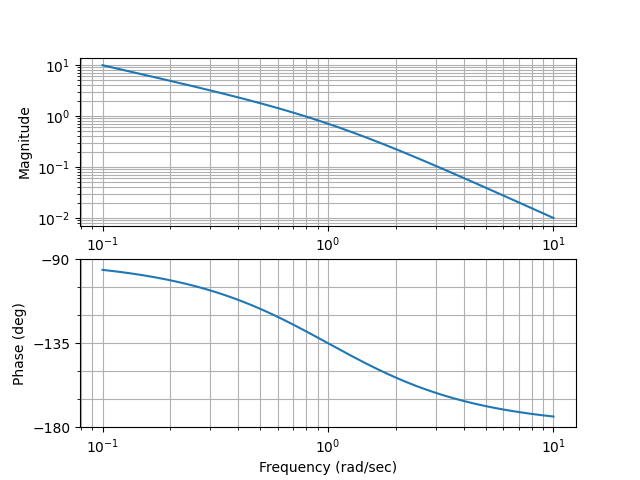

In [31]:
%matplotlib widget
plt.figure()
mag, phase, w = control.bode(sysG)

gm, pm, wp, wg = control.margin(sysG)
print(f'PM = {pm:.2f}')
print(f'wg = {wg:.2f}')


### PD Control

We choose $T_d$ such that $\angle C(i\omega) G(i\omega) = \angle (1+iT_d\omega) + \angle G(i\omega) \geq -135^\circ$ when $\omega=10$.

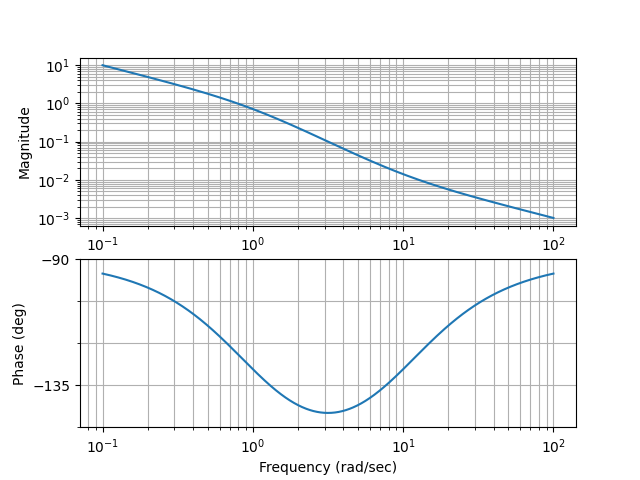

In [32]:
%matplotlib widget

Td = 0.1
sysC0 = control.tf([Td, 1],1)

plt.figure()
mag, phase, w = control.bode(sysC0*sysG)



Next, we choose $K$ such that $|C(i\omega) G(i\omega)| = K | C_0(i\omega) G(i\omega) | =1 $ at $\omega=10$.

In [33]:
%matplotlib inline

wg = 10
mag, phase, w = control.bode(sysC0*sysG, [wg], plot=False)
K = 1/mag[0]

print(f'mag={mag[0]:.4f}')
print(f'K={K:.2f}')


mag=0.0141
K=71.06


The frequency response of the controlled system is

PM = 50.71
wg = 10.00


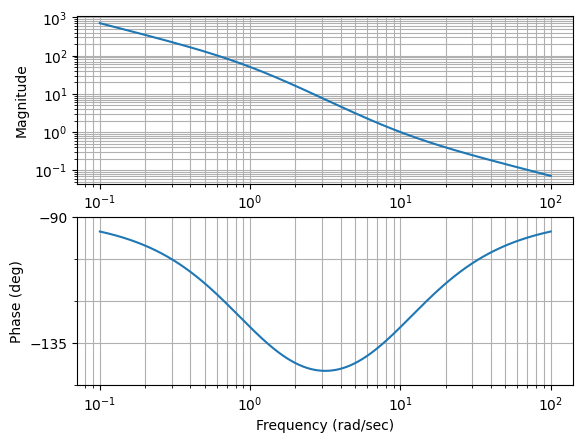

In [35]:
%matplotlib inline 

sysC = K*sysC0

plt.figure()
mag, phase, w = control.bode(sysC*sysG)

gm, pm, wp, wg = control.margin(sysC*sysG)
print(f'PM = {pm:.2f}')
print(f'wg = {wg:.2f}')


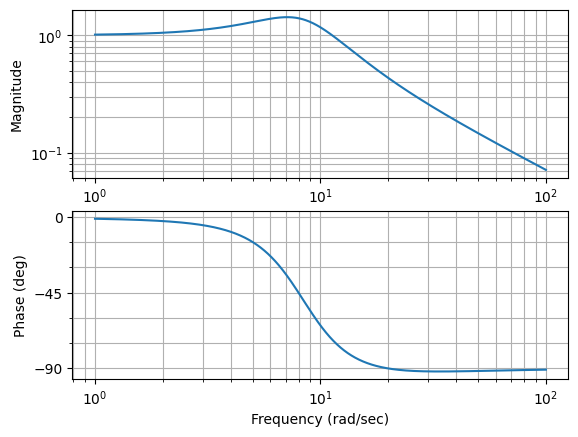

In [36]:
%matplotlib inline

sysYR = control.feedback(sysC*sysG,1)
plt.figure()
mag, phase, w = control.bode(sysYR)


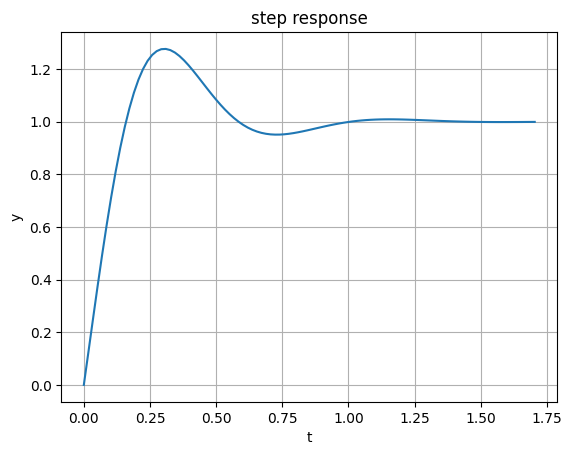

In [37]:


t, y = control.step_response(sysYR)
plt.plot(t,y)
plt.xlabel('t')
plt.ylabel('y')
plt.title('step response')
plt.grid()